# Traffic sign classifier

## Machine Learning Project: Build a Traffic Sign Classifier

---
**Disclaimer**

This project aims to be a study and a reworking of [this](https://github.com/lfiaschi/udacity-traffic-sign-classifier) notebook.

In [1]:
import cv2 # resize the images
import numpy as np
import pandas as pd
import os # to work with directories
from random import shuffle # shuffle data
import warnings
warnings.filterwarnings('ignore')

DATASET_DIR = '/datasets/GTSRB/Images/'
ANNOTATION_FILE = './signnames.csv'



IMAGE_SIZE = 32
# LR = 1e-3
# MODEL_NAME = 'trafficsigns--{}--{}.model'.format(LR, "2conv-basic")

Load the csv file with the annotations

In [2]:
signnames = pd.read_csv(ANNOTATION_FILE)
signnames.set_index('ClassId',inplace=True) 
print(signnames[:5])

def get_name_from_label(label):
    """Return the textual name corresponding to the numeric class id
    
    this functions look for a correspondence between the numeric class id 
    and the textual name of the class.
    
    :param label: the numeric class id
    :type label: int
    :returns: the textual name of the class
    
    :Example:

    >>> get_name_from_label(0)
    Speed limit (20km/h)   
    """    
    
    return signnames.loc[label].SignName

                     SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)


The images are divided into folders based on their category. The *load_dataset* function create a list of all the images labeled with the name of their folder.

In [3]:
def load_dataset(path):
    """Load a dataset of images given a path
    
    this function look for images on the subfolders of the given path and label 
    them with the name of the folder where the image is stored
    
    :param path: the path where the images divided into folders are stored
    :returns: a numpy array    
    """
    dataset = []
    for subdir, dirs, files in os.walk(path): # all file on the dataset folder
        for file in files: # one image by one
            
            filename, file_extension = os.path.splitext(file) # extension control
            if file_extension == '.ppm':
                label = os.path.basename(subdir) # obtain the image label (name of the folder)
                imgPath = os.path.join(path, label, file) # the path of the image
                
                # load image with cv2 library
                # img = cv2.imread(imgPath, 0)  
                # img = cv2.resize(cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE), (IMAGE_SIZE, IMAGE_SIZE))
                img = cv2.resize(cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB), (IMAGE_SIZE, IMAGE_SIZE))
                label = int(label) # remove the zeros ahead the name of the folder
                
                # dataset.append([np.array(img), np.array(label)])
                # dataset.append([imgNp, label])
                dataset.append([np.array(img), np.array(str(label))])
                       
    shuffle(dataset)
    # np.save('dataset.npy', dataset)
    return dataset

In [4]:
def load_dataset2(path):
    """Load a dataset of images given a path
    
    this function look for images on the subfolders of the given path and label 
    them with the name of the folder where the image is stored
    
    :param path: the path where the images divided into folders are stored
    :returns: a numpy array    
    """
    dataset2 = {}
    dataset2['features'] = []
    dataset2['labels'] = []
    
    
    for subdir, dirs, files in os.walk(path): # all file on the dataset folder
        for file in files: # one image by one
            
            filename, file_extension = os.path.splitext(file) # extension control
            if file_extension == '.ppm':
                label = os.path.basename(subdir) # obtain the image label (name of the folder)
                imgPath = os.path.join(path, label, file) # the path of the image
                
                # load image with cv2 library
                # img = cv2.imread(imgPath, 0)  
                # img = cv2.resize(cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE), (IMAGE_SIZE, IMAGE_SIZE))
                img = cv2.resize(cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB), (IMAGE_SIZE, IMAGE_SIZE))
                label = int(label) # remove the zeros ahead the name of the folder
                
                dataset2['features'].append(np.asarray(img))
                dataset2['labels'].append(label)
                
                # dataset.append([np.array(img), np.array(str(label))])
                       
    # shuffle(dataset2)
    # np.save('dataset.npy', dataset)
    return dataset2

In [5]:
from sklearn.model_selection import train_test_split

dataset = load_dataset2(DATASET_DIR)

X, y = dataset['features'], dataset['labels']
#prende il 70% per il train e il 30% per il test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)


# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Number of testing examples.
n_valid = len(X_valid)

# What's the shape of an traffic sign image?
# image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)

print("Number of testing examples =", n_test)

# print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


#print("dataset cardinality : {}".format(len(dataset)))

#stampa del dataset sotto forma di numpy array. (giusto?)
# print(dataset['labels'][0]) # stampa di una delle foto


Number of training examples = 27446
Number of validation examples = 5882
Number of testing examples = 5881
Number of classes = 43


TODO cercare di ottenere X_train, y_train, X_valid, y_valid per allienarci con il progetto originale

## Select data to create the trainingset and the testset

In [6]:
# training_set = dataset[:-5000] # take all the images except the last 5000
# test_set = dataset[-5000:] # take the last 5000 images
# print("training set cardinality : {}".format(len(training_set)))
# print("testset cardinality : {}".format(len(test_set)))

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

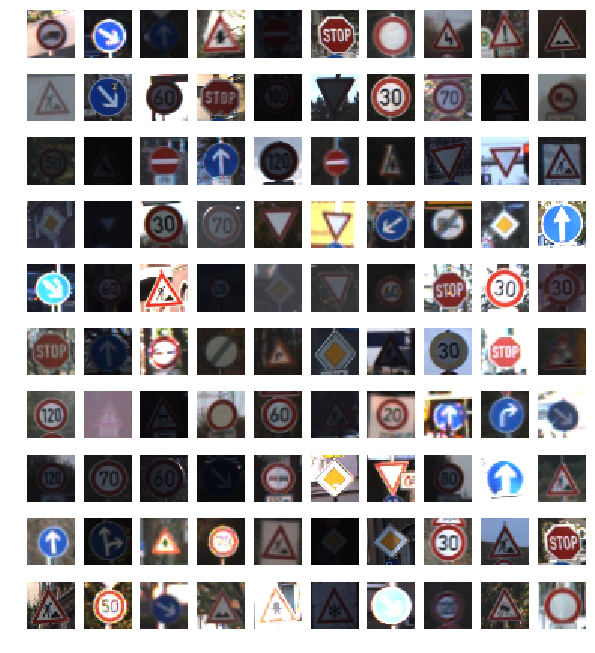

In [8]:
plt.figure(figsize=(10,50))
count = 0
cols = 10
for i in range(100):
    count += 1
    plt.subplot(43, cols, count)
    #plt.imshow(X_train[ii])
    plt.imshow(X_train[i])
    plt.axis('off')

In [10]:
import seaborn as sns
from collections import Counter


In [11]:
counter = Counter(y_train)

# conta il numero di samples per categoria (min , max , mean)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                np.max(list(Counter(y_train).values())) ))
print()
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))

Train example per class mean 638 min 143 max 1573

Most common signs:
'Speed limit (50km/h)'  train samples: 1573
'Speed limit (30km/h)'  train samples: 1529
'Yield'  train samples: 1509
'Priority road'  train samples: 1499
'Keep right'  train samples: 1467
'No passing for vehicles over 3.5 metric tons'  train samples: 1405
'Speed limit (70km/h)'  train samples: 1402
'Speed limit (80km/h)'  train samples: 1314
'Road work'  train samples: 1047
'No passing'  train samples: 1037

Most rare signs:
'Dangerous curve to the left'  train samples: 143
'Speed limit (20km/h)'  train samples: 144
'Go straight or left'  train samples: 153
'End of all speed and passing limits'  train samples: 166
'End of no passing by vehicles over 3.5 metric tons'  train samples: 168
'End of no passing'  train samples: 175
'Keep left'  train samples: 184
'Pedestrians'  train samples: 184
'Bicycles crossing'  train samples: 193
'Road narrows on the right'  train samples: 201


In [12]:
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label) 

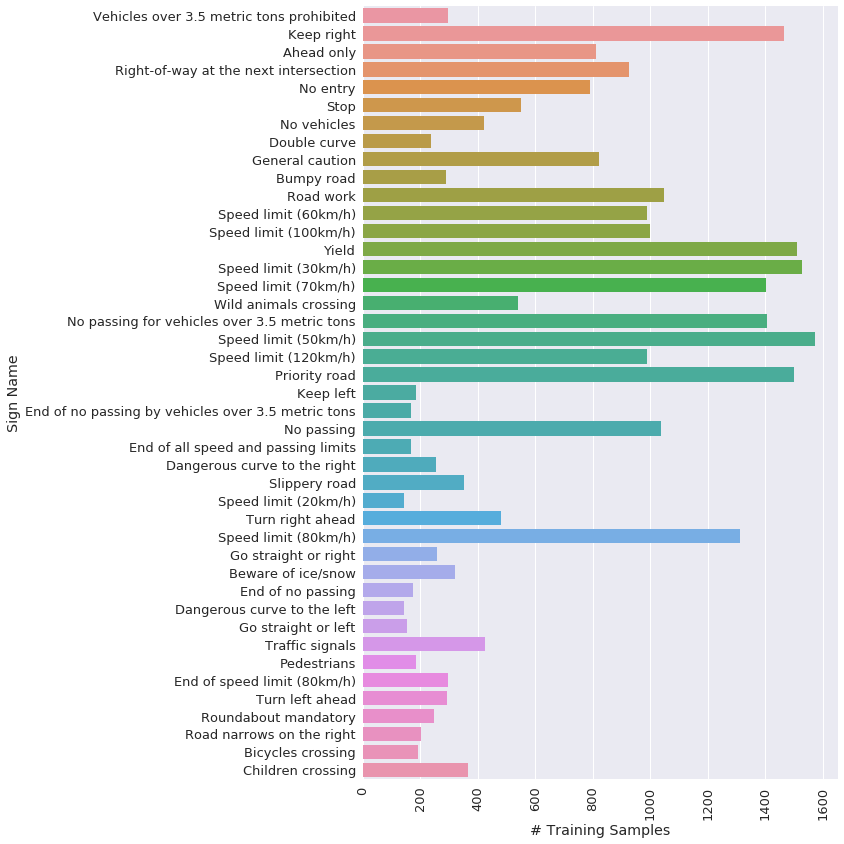

In [13]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3)
sns.barplot(x='training_samples_count',y='sign',data=counts,orient='V')
plt.xticks(rotation=90)
plt.ylabel('Sign Name')
plt.xlabel('# Training Samples');
plt.tight_layout()